In [73]:
import numpy as np
import pandas as pd
import load_rating_data as ld
from utils import sigmoid
import copy
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

In [74]:
class BPR():
    
    def __init__(self, R, val_R, latent_size=50, ld=1e-3, learning_rate=0.001, epochs=200):
        
        self._R = R             # explicit matrix
        self._val_R = val_R
        self._I = copy.deepcopy(self._R)    # implicit matrix
        self._I[self._I != 0] = 1
        self._val_I = copy.deepcopy(self._val_R)    # implicit matrix
        self._val_I[self._val_I != 0] = 1
        self._N, self._M = R.shape
        self._latent = latent_size
        self._lr = learning_rate
        self._epochs =epochs
        self._lambda = ld        
        self._P = np.random.normal(0, 0.1, size=(self._N, latent_size))
        self._Q = np.random.normal(0, 0.1, size=(self._M, latent_size))
        self._Y = np.random.normal(0, 0.1, size=(self._M, latent_size))
        self._B = np.random.normal(0, 0.1, size=(self._N, self._M))
                
    def update(self):
        for iter in range(10000):
            x, y = np.nonzero(self._I)
            while(True):
                u = np.random.choice(x)
                i = np.random.choice(np.nonzero(self._I[u, :])[0])
                arr = np.where(self._I[u, :] == 0)[0]
                if arr[0].size == 0:
                    continue
                else:
                    j = np.random.choice(arr)
                    break
            
            xuij = self._P[u].dot(self._Q[i].T) - self._P[u].dot(self._Q[j].T)
            sigmoid_prime = sigmoid(xuij) * np.exp(-xuij)
            self._P[u, :] += self._lr * (sigmoid_prime * (self._Q[i] - self._Q[j]) - 2 * self._lambda * self._P[u])
            self._Q[i, :] += self._lr * (sigmoid_prime * self._P[u] - 2 * self._lambda * self._Q[i])
            self._Q[j, :] += self._lr * (-1 * sigmoid_prime * self._P[u] - 2 * self._lambda * self._Q[j])

    def train(self):
        
        auc_list = []
        start_time = timer()
        for epoch in range(self._epochs):
            start = timer()
            
            self.update()
            train_auc = self.AUC()
                
            auc_list.append(train_auc)
            
            print('traning iteration:{: d} ,train_auc:{: f}, time:{: f}'.format(epoch, train_auc, timer() - start))
                
        print("Total time for training : %.4f" % (timer()-start_time))
        return self._P, self._Q, auc_list   

In [75]:
df = ld.load_rating_data()
N, M = len(df.user_id.unique()), len(df.item_id.unique())
ratio = 0.8
print("N, M : ", N, M)
train, test = train_test_split(df, test_size=1-ratio)
val, test = train_test_split(test, test_size=0.5)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

N, M :  943 1682


In [76]:
R = np.zeros([N, M])    
for i in range(len(train)):
    R[int(train.iloc[i, 0])-1, int(train.iloc[i, 1])-1] = float(train.iloc[i, 2])

val_R = np.zeros([N, M])    
for i in range(len(val)):
    val_R[int(val.iloc[i, 0])-1, int(val.iloc[i, 1])-1] = float(val.iloc[i, 2])

In [78]:
bpr1 = BPR(R, val_R, latent_size=20, ld=0.01, learning_rate=0.1, epochs=10)
P1, Q1, auc_list1 = bpr1.train()

traning iteration: 0 ,train_auc: 0.503479, time: 287.628113
traning iteration: 1 ,train_auc: 0.500415, time: 306.973320
traning iteration: 2 ,train_auc: 0.555039, time: 300.263092
traning iteration: 3 ,train_auc: 0.628547, time: 301.136443
traning iteration: 4 ,train_auc: 0.776052, time: 272.930271
traning iteration: 5 ,train_auc: 0.799645, time: 168.487843
traning iteration: 6 ,train_auc: 0.825378, time: 164.918288
traning iteration: 7 ,train_auc: 0.827317, time: 131.507776
traning iteration: 8 ,train_auc: 0.846624, time: 129.845471
traning iteration: 9 ,train_auc: 0.845547, time: 129.191594
Total time for training : 2192.8950


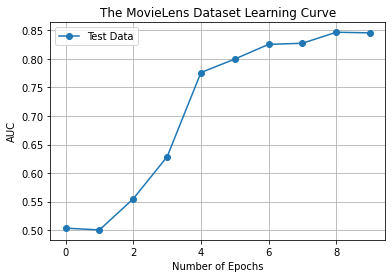

In [80]:
import matplotlib.pyplot as plt

# Check performance by plotting train and test errors
n = 10
m = 0
plt.plot(range(m, n), auc_list1[m:n], marker='o', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()